In [276]:
import re
import zipfile
import os
import sys
import pandas as pd

In [281]:
movdf_norm.head()

,Unnamed: 0,Unnamed: 0.1,Movie Name,Genre,Year,Country,IMDb,Tokenized,Text,word_count,normalized_tokens,Tagged_Female,Tagged_Male
0,0,3547424,Goodbye to All That,"Short, Musical",1930,English,290635,"['In', 'the', 'future', 'a', 'computer', 'prog...","@3547424 In the future , a computer program ca...",35320,"['future', 'computer', 'program', 'called', 's...","([future, computer, program, called, skynet, d...","([future, computer, program, called, skynet, d..."
1,1,3660608,Abraham Lincoln,"Biography, Drama, History",1930,English,20620,"['Tom', 'Lincoln', 'It', ""'s"", 'a', 'comin', '...",@3660608 Tom Lincoln ! It's a comin ' - Boy or...,49770,"['tom', 'lincoln', 'comin', 'boy', 'gal', 't',...","([tom, lincoln, comin, boy, gal, t, ai, nt, fu...","([tom, lincoln, comin, boy, gal, t, ai, nt, fu..."
2,2,60053,All Quiet on the Western Front,"Drama, War",1930,"English, French, German, Latin",20629,"['Thirty', 'thousand', 'From', 'the', 'Russian...",@60053 - Thirty thousand . - From the Russians...,69596,"['russians', 'french', 'russians', 'capture', ...","([russians, french, russians, capture, day, mr...","([russians, french, russians, capture, day, mr..."
3,3,3435788,Born Reckless,"Crime, Drama, Film-Noir",1930,"English, Italian, French",20702,"['Louis', 'Louis', 'Beretti', 'Shh', 'Put', 't...",@3435788 Louis ? Louis ? - Beretti ? - Shh ! P...,49565,"['louis', 'louis', 'beretti', 'shh', 'sap', 'k...","([louis, louis, beretti, shh, sap, know, bette...","([louis, louis, beretti, shh, sap, know, bette..."
4,4,6922578,King of Jazz,"Animation, Music",1930,English,21025,"['Music', 'hath', 'charms', 'that', 'nothing',...",@6922578 Music hath charms that nothing else h...,33966,"['music', 'hath', 'charms', 'music', 'hath', '...","([music, hath, charms, music, hath, charms, cl...","([music, hath, charms, music, hath, charms, cl..."


In [277]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud_2020

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

In [21]:
title_basics_df = pd.read_csv('title.basics.tsv.gz', sep='\t')
title_cast_df = pd.read_csv('title.principals.tsv.gz', sep='\t')
title_ratings_df = pd.read_csv('title.ratings.tsv.gz', sep='\t')

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [22]:
movie_metadata = pd.read_csv(r'\Users\iarak\OneDrive\Desktop\CCA\imdb-5000-movie-dataset\movie_metadata.csv')

In [23]:
movie_metadata['movie_title'].head()

0                                              Avatar 
1            Pirates of the Caribbean: At World's End 
2                                             Spectre 
3                               The Dark Knight Rises 
4    Star Wars: Episode VII - The Force Awakens    ...
Name: movie_title, dtype: object

In [24]:
movie_metadata.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes'],
      dtype='object')

In [25]:
## Helper Functions
def clean_year(y):
    # Return year as an integer or 'NaN' if empty
    import numpy as np
    try:
        return int(y)
    except:
        return np.nan

def clean_genre(y):
    # Return only the first genre listed
    y = str(y)
    if y == '\\N':
        return ''
    return y.split(',')[0].strip()

title_basics_df.drop('endYear', axis=1, inplace=True)
title_basics_df['startYear'] = title_basics_df['startYear'].apply(clean_year)
title_basics_df['runtimeMinutes'] = title_basics_df['runtimeMinutes'].apply(clean_year)
title_basics_df['genres'] = title_basics_df['genres'].apply(clean_genre)
title_basics_df.dropna(inplace=True, how='any', subset=['startYear', 'runtimeMinutes'])

In [26]:
mask = ((title_basics_df['startYear'] >= 1930) &
        (title_basics_df['startYear'] <= 2017) &
        (title_basics_df['titleType'] == 'movie') &
        (title_basics_df['isAdult'] == 0) & 
        (title_basics_df['runtimeMinutes'] > 80) &
        (title_basics_df['genres'] != ''))

In [27]:
titles = title_basics_df[mask].merge(title_cast_df, on='tconst')
titles = titles.merge(title_ratings_df, on='tconst')

In [28]:
import pickle
with open('my_data.pkl', 'wb') as picklefile:
   pickle.dump(titles['tconst'].values, picklefile)

In [3]:
corpus_name = r"C:\Users\iarak\OneDrive\Desktop\CCA\Movies"

In [4]:
def loadcorpus(corpus_name, corpus_style="text"):
    texts_raw = {}
    for file in os.listdir(corpus_name + "/"):
        if corpus_style in file:
            print(file)
            zfile = zipfile.ZipFile(corpus_name + "/" + file)
            for file in zfile.namelist():
                texts_raw[file] = []
                with zfile.open(file) as f:
                    for line in f:
                        texts_raw[file].append(line)
    return texts_raw

In [5]:
movie_raw = loadcorpus(corpus_name)

text_00_myn.zip
text_01_ote.zip
text_02_mqu.zip
text_03_mnq.zip
text_04_mlq.zip
text_05_nko.zip
text_06_jfy.zip
text_07_oma.zip
text_08_loh.zip
text_09_oii.zip
text_10_aoy.zip
text_11_uoy.zip
text_12_rcq.zip
text_13_idi.zip
text_14_lnc.zip
text_15_guo.zip
text_16_qll.zip
text_17_arp.zip
text_18_jfj.zip
text_19_gvc.zip
text_20_cde.zip
text_21_fqa.zip
text_22_etp.zip
text_23_fmh.zip
text_24_ywo.zip
text_25_byg.zip
text_26_ngj.zip
text_27_fle.zip
text_28_rfy.zip
text_29_oye.zip
text_30_wkp.zip
text_31_akv.zip
text_32_ldf.zip
text_33_kje.zip


In [6]:
zfile = zipfile.ZipFile(corpus_name + "/sources_movies.zip")
source = []

In [7]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [8]:
def clean_raw_text(raw_texts):
    clean_texts = []
    for text in raw_texts:
        try:
            text = text.decode("utf-8")
            clean_text = text.replace(" \'m", "'m").replace(" \'ll", "'ll").replace(" \'re", "'re").replace(" \'s", "'s").replace(" \'re", "'re").replace(" n\'t", "n't").replace(" \'ve", "'ve").replace(" /'d", "'d")
            clean_texts.append(clean_text)
        except AttributeError:
            # print("ERROR CLEANING")
            # print(text)
            continue
        except UnicodeDecodeError:
            # print("Unicode Error, Skip")
            continue
    return clean_texts

In [9]:
movie_texts = {}

In [10]:
for files in movie_raw:
    if len(movie_texts) > 2000:
        break
    movies = clean_raw_text(movie_raw[files][1:])
    for movie in movies:
        txts = lucem_illud_2020.word_tokenize(movie) #whenever I would sub the word_tokenize function for 
                                                        #nltk or nltk.tokenize.word_tokenize, it would get stuck
        try:
            movie_texts[txts[0][2:]] = txts[1:]
        except IndexError:
            continue

In [11]:
movie_df = pd.DataFrame(columns=["Movie Name", "Genre", "Year", "Country","IMDb", "Tokenized"])

In [12]:
for movie in source[3:]:
    try:
        tid, fileid, total_words, genre, year, lang, country, imdb, title = movie.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    try:
        movie_df.loc[fileid.strip()] = [title.strip(), genre.strip(), year.strip(), country.strip(), imdb.strip(), movie_texts[fileid.strip()]]
    except KeyError:
        continue

In [38]:
movie_df.to_csv("movdf_tok2k.csv")

In [13]:
movies_texts = {}

In [14]:
for files in movie_raw:
    if len(movies_texts) > 2000:
        break
    movies = clean_raw_text(movie_raw[files][1:])
    for movie in movies:
        txts = lucem_illud_2020.word_tokenize(movie)
        try:
            movies_texts[txts[0][2:]] = movie[1:]
        except IndexError:
            continue

In [15]:
movies_df = pd.DataFrame(columns=["Movie Name", "Genre", "Year", "Country","IMDb", "Text"])

In [16]:
for movie in source[3:]:
    try:
        tid, fileid, total_words, genre, year, lang, country, imdb, title = movie.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    try:
        movies_df.loc[fileid.strip()] = [title.strip(), genre.strip(), year.strip(), country.strip(),imdb.strip(), movies_texts[fileid.strip()]]
    except KeyError:
        continue

In [28]:
movies_df.to_csv(r"C:\Users\iarak\OneDrive\Desktop\CCA\Movies\movdf_text2k.csv")

In [37]:
movies_df.to_csv("movdf_text2k.csv")

In [43]:
tok = pandas.read_csv("movdf_tok2k.csv")

In [44]:
tex = pandas.read_csv("movdf_text2k.csv")

In [197]:
movdf_tok10k = pandas.read_csv("movdf_tok10k.csv")

In [198]:
movdf_text10k = pandas.read_csv("movdf_text10k.csv")

In [46]:
tok.head()

,Unnamed: 0,Movie Name,Genre,Year,Country,IMDb,Tokenized,normalized_words
0,3435788,Born Reckless,"Crime, Drama, Film-Noir",1930,"English, Italian, French",20702,"['Louis', 'Louis', 'Beretti', 'Shh', 'Put', 't...","['louis', 'louis', 'beretti', 'shh', 'sap', 'k..."
1,3147360,The Devil's Parade,Short,1930,English,225503,"['Good', 'luck', 'Hi', 'Uh', 'I', 'have', 'an'...","['good', 'luck', 'hi', 'uh', 'appointment', 'e..."
2,6880640,Dishonored,"Drama, Romance, War",1931,English,21800,"['I', 'thought', 'I', 'smelled', 'gas', 'That'...","['thought', 'smelled', 'gas', 'year', 'decency..."
3,5482259,Indiscreet,"Comedy, Drama, Musical",1931,English,22000,"['Subtitles', 'Lu', 's', 'Filipe', 'Bernardes'...","['subtitles', 'lu', 's', 'filipe', 'bernardes'..."
4,3276830,Smart Money,"Crime, Drama",1931,English,22403,"['Aces', 'Fine', 'Come', 'on', 'ace', 'Ah', 'T...","['aces', 'fine', 'come', 'ace', 'ah', 'thank',..."


In [45]:
tex.head()

,Unnamed: 0,Movie Name,Genre,Year,Country,IMDb,Text
0,3435788,Born Reckless,"Crime, Drama, Film-Noir",1930,"English, Italian, French",20702,@3435788 Louis ? Louis ? - Beretti ? - Shh ! P...
1,3147360,The Devil's Parade,Short,1930,English,225503,"@3147360 Good luck . Hi . Uh , I have an appoi..."
2,6880640,Dishonored,"Drama, Romance, War",1931,English,21800,@6880640 I thought I smelled gas . That's thre...
3,5482259,Indiscreet,"Comedy, Drama, Musical",1931,English,22000,@5482259 Subtitles : Lu ? s Filipe Bernardes W...
4,3276830,Smart Money,"Crime, Drama",1931,English,22403,"@3276830 Aces . Fine . Come on , ace . Ah . Th..."


In [53]:
t_column = tex["Text"]
movie_df2k = pd.concat([tok,t_column], axis = 1)

#pd.merge(left=tok, right=tex, left_on='Unnamed: 0', right_on='Unnamed: 0', how='left')

In [199]:
t10_column = movdf_text10k["Text"]
movie_df10k = pd.concat([movdf_tok10k,t10_column], axis = 1)

#pd.merge(left=tok, right=tex, left_on='Unnamed: 0', right_on='Unnamed: 0', how='left')

In [220]:
movie_df10k.head()

,Unnamed: 0,Movie Name,Genre,Year,Country,IMDb,Tokenized,Text
0,3547424,Goodbye to All That,"Short, Musical",1930,English,290635,"['In', 'the', 'future', 'a', 'computer', 'prog...","@3547424 In the future , a computer program ca..."
1,3660608,Abraham Lincoln,"Biography, Drama, History",1930,English,20620,"['Tom', 'Lincoln', 'It', ""'s"", 'a', 'comin', '...",@3660608 Tom Lincoln ! It's a comin ' - Boy or...
2,60053,All Quiet on the Western Front,"Drama, War",1930,"English, French, German, Latin",20629,"['Thirty', 'thousand', 'From', 'the', 'Russian...",@60053 - Thirty thousand . - From the Russians...
3,3435788,Born Reckless,"Crime, Drama, Film-Noir",1930,"English, Italian, French",20702,"['Louis', 'Louis', 'Beretti', 'Shh', 'Put', 't...",@3435788 Louis ? Louis ? - Beretti ? - Shh ! P...
4,6922578,King of Jazz,"Animation, Music",1930,English,21025,"['Music', 'hath', 'charms', 'that', 'nothing',...",@6922578 Music hath charms that nothing else h...


In [14]:
movies_df['tokenized_words'] = movies_df['Text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
movies_df['normalized_words'] = movies_df['tokenized_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

In [93]:
movie_df10k['word_count'] = movie_df10k['Tokenized'].apply(lambda x: len(x))

In [306]:
mov_romance = movdf_norm[movdf_norm['Genre'].str.contains('Romance', na=False)] #114 movies

In [307]:
mov_drama = movdf_norm[movdf_norm['Genre'].str.contains('Drama', na=False)] #114 movies

In [309]:
mov_comedy = movdf_norm[movdf_norm['Genre'].str.contains('Comedy', na=False)] #114 movies

In [310]:
mov_horror = movdf_norm[movdf_norm['Genre'].str.contains('Horror', na=False)] #114 movies

In [311]:
mov_scifi = movdf_norm[movdf_norm['Genre'].str.contains('Sci-Fi', na=False)] #114 movies

In [308]:
mov_sport = movdf_norm[movdf_norm['Genre'].str.contains('Sport', na=False)] #114 movies

In [94]:
movie_df10k_genre = pd.concat([movie_df10k,movie_df10k.Genre.str.get_dummies(sep=', ')],1)

In [278]:
import spacy
import en_core_web_sm

In [279]:
nlp = spacy.load('en_core_web_sm')

In [74]:
def word_tokenize(word_list):
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

In [75]:
def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pandas.DataFrame(countsForFrame)

In [280]:
import networkx as nx

In [237]:
is_1930s =  movdf_norm['Year'].isin(["1930", "1931","1932", "1933", "1934", "1935", "1936", "1937", "1938", "1939"])
only_1930s = movdf_norm[is_1930s]

In [289]:
is_1940s =  movdf_norm['Year'].isin(["1940", "1941","1942", "1943", "1944", "1945", "1946", "1947", "1948", "1949"])
only_1940s = movdf_norm[is_1940s]

In [290]:
is_1950s =  movdf_norm['Year'].isin(["1950", "1951","1952", "1953", "1954", "1955", "1956", "1957", "1958", "1959"])
only_1950s = movdf_norm[is_1950s]

In [288]:
movdf_norm.head()

,Unnamed: 0,Unnamed: 0.1,Movie Name,Genre,Year,Country,IMDb,Tokenized,Text,word_count,normalized_tokens,Tagged_Female,Tagged_Male
0,0,3547424,Goodbye to All That,"Short, Musical",1930,English,290635,"['In', 'the', 'future', 'a', 'computer', 'prog...","@3547424 In the future , a computer program ca...",35320,"['future', 'computer', 'program', 'called', 's...","([future, computer, program, called, skynet, d...","([future, computer, program, called, skynet, d..."
1,1,3660608,Abraham Lincoln,"Biography, Drama, History",1930,English,20620,"['Tom', 'Lincoln', 'It', ""'s"", 'a', 'comin', '...",@3660608 Tom Lincoln ! It's a comin ' - Boy or...,49770,"['tom', 'lincoln', 'comin', 'boy', 'gal', 't',...","([tom, lincoln, comin, boy, gal, t, ai, nt, fu...","([tom, lincoln, comin, boy, gal, t, ai, nt, fu..."
2,2,60053,All Quiet on the Western Front,"Drama, War",1930,"English, French, German, Latin",20629,"['Thirty', 'thousand', 'From', 'the', 'Russian...",@60053 - Thirty thousand . - From the Russians...,69596,"['russians', 'french', 'russians', 'capture', ...","([russians, french, russians, capture, day, mr...","([russians, french, russians, capture, day, mr..."
3,3,3435788,Born Reckless,"Crime, Drama, Film-Noir",1930,"English, Italian, French",20702,"['Louis', 'Louis', 'Beretti', 'Shh', 'Put', 't...",@3435788 Louis ? Louis ? - Beretti ? - Shh ! P...,49565,"['louis', 'louis', 'beretti', 'shh', 'sap', 'k...","([louis, louis, beretti, shh, sap, know, bette...","([louis, louis, beretti, shh, sap, know, bette..."
4,4,6922578,King of Jazz,"Animation, Music",1930,English,21025,"['Music', 'hath', 'charms', 'that', 'nothing',...",@6922578 Music hath charms that nothing else h...,33966,"['music', 'hath', 'charms', 'music', 'hath', '...","([music, hath, charms, music, hath, charms, cl...","([music, hath, charms, music, hath, charms, cl..."


In [295]:
is_1960s =  movdf_norm['Year'].isin(["1960", "1961","1962", "1963", "1964", "1965", "1966", "1967", "1968", "1969"])
only_1960s = movdf_norm[is_1960s]

In [294]:
is_1970s =  movdf_norm['Year'].isin(["1970", "1971","1972", "1973", "1974", "1975", "1976", "1977", "1978", "1979"])
only_1970s = movdf_norm[is_1970s]

In [293]:
is_1980s =  movdf_norm['Year'].isin(["1980", "1981","1982", "1983", "1984", "1985", "1986", "1987", "1988", "1989"])
only_1980s = movdf_norm[is_1980s]

In [292]:
is_1990s =  movdf_norm['Year'].isin(["1990", "1991","1992", "1993", "1994", "1995", "1996", "1997", "1998", "1999"])
only_1990s = movdf_norm[is_1990s]

In [291]:
is_2000s =  movdf_norm['Year'].isin(["2000", "2001","2002", "2003", "2004", "2005", "2006", "2007", "2008", "2009"])
only_2000s = movdf_norm[is_2000s]

In [238]:
is_2010s =  movdf_norm['Year'].isin(["2010", "2011","2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019"])
only_2010s = movdf_norm[is_2010s]

In [356]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk import tokenize
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\iarak\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\iarak\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [106]:
only_1950s

,Unnamed: 0,Movie Name,Genre,Year,Country,IMDb,Tokenized,Text,word_count
669,217801,Teamwork: Past and Present,"Animation, Short",1950,English,242025,"['Cinema', 'Service', 'In', 'Cooperation', 'wi...",@217801 Cinema Service In Cooperation with Inf...,60919
670,5128801,Fugitive Lady,"Crime, Drama",1950,English,41925,"['Is', 'it', 'your', 'husband', 'Spare', 'your...",@5128801 Is it your husband ? Spare yourself t...,52783
671,5221380,Gone to Earth,"Drama, Romance",1950,English,42513,"['Gone', 'to', 'earth', 'Foxy', 'They', ""'re"",...",@5221380 Gone to earth ! Foxy ? They're out to...,40611
672,3614423,Madeleine,"Crime, Drama",1950,English,42700,"['NARRATOR', 'In', 'this', 'great', 'city', 'o...",@3614423 NARRATOR : In this great city of Glas...,77463
673,6977128,The Astonished Heart,"Drama, Romance",1950,English,41134,"['The', 'Astonished', 'Heart', 'Subtitles', 'b...",@6977128 The Astonished Heart Subtitles by Seg...,81802
...,...,...,...,...,...,...,...,...,...
1122,3150118,The Horse Soldiers,"Adventure, Romance, War",1959,English,52902,"['I', 'left', 'my', 'love', 'my', 'love', 'I',...","@3150118 I left my love , my love I left A-sle...",69778
1123,6667519,The Immoral Mr. Teas,Comedy,1959,English,52920,"['For', 'years', 'man', 'has', 'retreated', 'b...",@6667519 For years man has retreated back to n...,9647
1124,6898426,The Naked Venus,Drama,1959,English,144415,"['No', 'we', 'must', 'get', 'closer', 'Now', '...","@6898426 No , we must get closer . Now , that'...",62365
1125,4772801,The Nun's Story,Drama,1959,English,53131,"['He', 'that', 'shall', 'lose', 'his', 'life',...","@4772801 "" He that shall lose his life for me ...",72824


In [107]:
only_2000s

,Unnamed: 0,Movie Name,Genre,Year,Country,IMDb,Tokenized,Text,word_count
4054,3546996,Dogwoman: Dead Dog Walking,"Comedy, Mystery",2000,English,242414,"['Hey', 'mister', 'Get', 'over', 'here', 'Hey'...","@3546996 Hey , mister . Get over here . Hey ! ...",32350
4055,6250993,Looking for Alibrandi,"Comedy, Drama, Romance",2000,"English, Italian",217629,"['Josie', 'Put', 'the', 'music', 'back', 'on',...","@6250993 Josie ! Put the music back on , we ha...",8152
4056,6704233,Mr. Accident,Comedy,2000,English,156807,"['Dinner', ""'s"", 'ready', 'kids', 'Oh', 'boy',...","@6704233 Dinner's ready , kids . Oh , boy ! Eg...",49081
4057,6270680,The Wog Boy,Comedy,2000,English,216417,"['WOG', 'BritishEnglish', 'snakeoffensive', 'w...",@6270680 WOG ( BritishEnglish ; snakeoffensive...,45384
4058,49408,Better Than Sex,"Comedy, Drama, Romance",2000,English,236019,"['A', 'country', 'mesmerized', 'by', 'Japanese...",@49408 A country mesmerized by Japanese cultur...,38660
...,...,...,...,...,...,...,...,...,...
6672,3526695,Knowing,"Drama, Mystery, Sci-Fi, Thriller",2009,English,448011,"['Everyone', 'inside', 'now', 'Lucinda', 'we',...","@3526695 Everyone inside now ! Lucinda , we're...",54794
6673,3551145,State of Play,"Crime, Drama, Mystery",2009,"English, Cantonese",473705,"['CHATTERING', 'EXCLAIMING', '@horns_honking',...",@3551145 ( CHATTERING ) ( EXCLAIMING ) ( @horn...,100738
6674,3765934,Helen,Drama,2009,English,1012729,"['Birds_squawking', '@waves_crashing', 'Piano_...","@3765934 [Birds_squawking] , @waves_crashing [...",41300
6675,3640889,The Lovely Bones,"Drama, Fantasy, Thriller",2009,English,380510,"['I', 'remember', 'being', 'really', 'small', ...",@3640889 I remember being really small too sma...,45928


In [87]:
only_1950s['normalized_tokens_POS'] = [nltk.pos_tag(t) for t in only_1950s['Tokenized']]
reviewcfdist_WordtoPOS_50s = nltk.ConditionalFreqDist(only_1950s['normalized_tokens_POS'].sum())
reviewcfdist_POStoWord_50s = nltk.ConditionalFreqDist((p, w) for w, p in only_1950s['normalized_tokens_POS'].sum())

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [88]:
only_1950s.head()

,Unnamed: 0,Movie Name,Genre,Year,Country,IMDb,Tokenized,normalized_words,Text,word_count,normalized_tokens_POS
97,3614423,Madeleine,"Crime, Drama",1950,English,42700,"['NARRATOR', 'In', 'this', 'great', 'city', 'o...","['narrator', 'great', 'city', 'glasgow', 'squa...",@3614423 NARRATOR : In this great city of Glas...,77463,"[([, NN), (', ''), (N, NNP), (A, NNP), (R, NNP..."
98,5985738,Annie Get Your Gun,"Biography, Comedy, Musical",1950,English,42200,"['Who', ""'s"", 'got', 'the', 'stuff', 'that', '...","['got', 'stuff', 'wild', 'west', 'wild', 'plea...","@5985738 "" Who's got the stuff that made the W...",80813,"[([, NN), (', ''), (W, NNP), (h, NN), (o, NN),..."
99,3380824,Under My Skin,"Drama, Sport, Thriller",1950,"English, Italian, French",42005,"['Bell_Tolling_In_Distance', 'Tolling_Continue...","['bell_tolling_in_distance', 'tolling_continue...",@3380824 [Bell_Tolling_In_Distance] [Tolling_C...,58938,"[([, NN), (', ''), (B, NNP), (e, NN), (l, NN),..."
100,6406396,Outcast of the Islands,"Drama, Adventure",1951,English,45002,"['INDISTINCTWHISPERING', '@man_screams', 'MACH...","['indistinctwhispering', '@man_screams', 'mach...",@6406396 ( INDISTINCTWHISPERING ) - ( @man_scr...,77040,"[([, NN), (', ''), (I, PRP), (N, NNP), (D, NNP..."
101,6169646,The Tales of Hoffmann,"Fantasy, Music, Musical",1951,English,44103,"['Some', 'drink', 'drink', 'drink', 'drink', '...","['drink', 'drink', 'drink', 'drink', 'drink', ...","@6169646 Some drink , drink , drink , drink , ...",48519,"[([, NN), (', ''), (S, NNP), (o, MD), (m, VB),..."


In [ ]:
only_2000s['normalized_tokens_POS'] = [nltk.pos_tag(t) for t in only_2000s['Tokenized']]
reviewcfdist_WordtoPOS_00s = nltk.ConditionalFreqDist(only_2000s['normalized_tokens_POS'].sum())
reviewcfdist_POStoWord_00s = nltk.ConditionalFreqDist((p, w) for w, p in only_2000s['normalized_tokens_POS'].sum())

In [127]:
only_1930s['normalized_tokens'] = only_1930s['Tokenized'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [128]:
only_1940s['normalized_tokens'] = only_1940s['Tokenized'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [118]:
only_1950s['normalized_tokens'] = only_1950s['Tokenized'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [129]:
only_1960s['normalized_tokens'] = only_1960s['Tokenized'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [130]:
only_1970s['normalized_tokens'] = only_1970s['Tokenized'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [131]:
only_1980s['normalized_tokens'] = only_1980s['Tokenized'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [132]:
only_1990s['normalized_tokens'] = only_1990s['Tokenized'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [119]:
only_2000s['normalized_tokens'] = only_2000s['Tokenized'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [133]:
only_2010s['normalized_tokens'] = only_2010s['Tokenized'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [134]:
mov_romance['normalized_tokens'] = mov_romance['Tokenized'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [135]:
mov_drama['normalized_tokens'] = mov_drama['Tokenized'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [136]:
mov_comedy['normalized_tokens'] = mov_comedy['Tokenized'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [137]:
mov_horror['normalized_tokens'] = mov_horror['Tokenized'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [138]:
mov_scifi['normalized_tokens'] = mov_scifi['Tokenized'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [139]:
mov_sport['normalized_tokens'] = mov_sport['Tokenized'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [140]:
movie_df10k.count()

Unnamed: 0    9909
Movie Name    9909
Genre         9845
Year          9909
Country       9726
IMDb          9909
Tokenized     9909
Text          9909
word_count    9909
dtype: int64

In [141]:
frames = [only_1930s, only_1940s, only_1950s, only_1960s, only_1970s, only_1980s, only_1990s, only_2000s, only_2010s]
result = pd.concat(frames)

In [142]:
result.count()

Unnamed: 0           9909
Movie Name           9909
Genre                9845
Year                 9909
Country              9726
IMDb                 9909
Tokenized            9909
Text                 9909
word_count           9909
normalized_tokens    9909
dtype: int64

In [143]:
result.to_csv("movdf_norm.csv")

In [219]:
movdf_norm = pd.read_csv("movdf_norm.csv")

In [239]:
movdf_norm.head()

,Unnamed: 0,Unnamed: 0.1,Movie Name,Genre,Year,Country,IMDb,Tokenized,Text,word_count,normalized_tokens,Tagged_Female,Tagged_Male
0,0,3547424,Goodbye to All That,"Short, Musical",1930,English,290635,"['In', 'the', 'future', 'a', 'computer', 'prog...","@3547424 In the future , a computer program ca...",35320,"['future', 'computer', 'program', 'called', 's...","([future, computer, program, called, skynet, d...","([future, computer, program, called, skynet, d..."
1,1,3660608,Abraham Lincoln,"Biography, Drama, History",1930,English,20620,"['Tom', 'Lincoln', 'It', ""'s"", 'a', 'comin', '...",@3660608 Tom Lincoln ! It's a comin ' - Boy or...,49770,"['tom', 'lincoln', 'comin', 'boy', 'gal', 't',...","([tom, lincoln, comin, boy, gal, t, ai, nt, fu...","([tom, lincoln, comin, boy, gal, t, ai, nt, fu..."
2,2,60053,All Quiet on the Western Front,"Drama, War",1930,"English, French, German, Latin",20629,"['Thirty', 'thousand', 'From', 'the', 'Russian...",@60053 - Thirty thousand . - From the Russians...,69596,"['russians', 'french', 'russians', 'capture', ...","([russians, french, russians, capture, day, mr...","([russians, french, russians, capture, day, mr..."
3,3,3435788,Born Reckless,"Crime, Drama, Film-Noir",1930,"English, Italian, French",20702,"['Louis', 'Louis', 'Beretti', 'Shh', 'Put', 't...",@3435788 Louis ? Louis ? - Beretti ? - Shh ! P...,49565,"['louis', 'louis', 'beretti', 'shh', 'sap', 'k...","([louis, louis, beretti, shh, sap, know, bette...","([louis, louis, beretti, shh, sap, know, bette..."
4,4,6922578,King of Jazz,"Animation, Music",1930,English,21025,"['Music', 'hath', 'charms', 'that', 'nothing',...",@6922578 Music hath charms that nothing else h...,33966,"['music', 'hath', 'charms', 'music', 'hath', '...","([music, hath, charms, music, hath, charms, cl...","([music, hath, charms, music, hath, charms, cl..."


In [240]:
only_1930s

,Unnamed: 0,Unnamed: 0.1,Movie Name,Genre,Year,Country,IMDb,Tokenized,Text,word_count,normalized_tokens,Tagged_Female,Tagged_Male
0,0,3547424,Goodbye to All That,"Short, Musical",1930,English,290635,"['In', 'the', 'future', 'a', 'computer', 'prog...","@3547424 In the future , a computer program ca...",35320,"['future', 'computer', 'program', 'called', 's...","([future, computer, program, called, skynet, d...","([future, computer, program, called, skynet, d..."
1,1,3660608,Abraham Lincoln,"Biography, Drama, History",1930,English,20620,"['Tom', 'Lincoln', 'It', ""'s"", 'a', 'comin', '...",@3660608 Tom Lincoln ! It's a comin ' - Boy or...,49770,"['tom', 'lincoln', 'comin', 'boy', 'gal', 't',...","([tom, lincoln, comin, boy, gal, t, ai, nt, fu...","([tom, lincoln, comin, boy, gal, t, ai, nt, fu..."
2,2,60053,All Quiet on the Western Front,"Drama, War",1930,"English, French, German, Latin",20629,"['Thirty', 'thousand', 'From', 'the', 'Russian...",@60053 - Thirty thousand . - From the Russians...,69596,"['russians', 'french', 'russians', 'capture', ...","([russians, french, russians, capture, day, mr...","([russians, french, russians, capture, day, mr..."
3,3,3435788,Born Reckless,"Crime, Drama, Film-Noir",1930,"English, Italian, French",20702,"['Louis', 'Louis', 'Beretti', 'Shh', 'Put', 't...",@3435788 Louis ? Louis ? - Beretti ? - Shh ! P...,49565,"['louis', 'louis', 'beretti', 'shh', 'sap', 'k...","([louis, louis, beretti, shh, sap, know, bette...","([louis, louis, beretti, shh, sap, know, bette..."
4,4,6922578,King of Jazz,"Animation, Music",1930,English,21025,"['Music', 'hath', 'charms', 'that', 'nothing',...",@6922578 Music hath charms that nothing else h...,33966,"['music', 'hath', 'charms', 'music', 'hath', '...","([music, hath, charms, music, hath, charms, cl...","([music, hath, charms, music, hath, charms, cl..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,295,4655701,The Pointer,"Animation, Comedy, Family",1939,English,31803,"['And', 'when', 'the', 'game', 'is', 'first', ...","@4655701 "" And when the game is first sighted ...",2335,"['game', 'sighted', 'true', 'pointer', 'positi...","([game, sighted, true, pointer, position, circ...","([game, sighted, true, pointer, position, circ..."
296,296,94962,The Private Lives of Elizabeth and Essex,"Biography, Drama, History",1939,English,31826,"['There', 'he', 'is', 'How', 'nobly', 'he', 'b...",@94962 There he is ! How nobly he bears himsel...,86174,"['nobly', 'bears', 'oh', 'wonderful', 'man', '...","([nobly, bears, oh, wonderful, man, hero, carr...","([nobly, bears, oh, wonderful, man, hero, carr..."
297,297,4417553,The Rains Came,"Adventure, Drama, Romance",1939,English,31835,"['Good', 'morning', 'miss', 'macdaid', 'Good',...","@4417553 Good morning , miss macdaid . Good mo...",67649,"['good', 'morning', 'miss', 'macdaid', 'good',...","([good, morning, miss, macdaid, good, morning,...","([good, morning, miss, macdaid, good, morning,..."
298,298,49387,The Wizard of Oz,"Adventure, Family, Fantasy",1939,English,32138,"['The', 'Wizard', 'of', 'Oz', '1939', '29.97',...",@49387 The Wizard of Oz ( 1939 ) - 29.97 fps S...,73336,"['wizard', 'oz', 'fps', 'coming', 'toto', 'hur...","([wizard, oz, fps, coming, toto, hurt, tried, ...","([wizard, oz, fps, coming, toto, hurt, tried, ..."


In [421]:
keywords_black = ['black', 'african', 'negro', 'nigger', 'dark', 'dusky']

In [ ]:
keywords_white = ['white', 'caucasian', 'pale']

In [222]:
keywords = ['woman', 'women', 'girl', 'girls', 'she', 'her', 'hers', 'female', 'females']

In [223]:
taggedDocs = []
for index, row in result.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_tokens']]
    docKeywords.append(row['Year'])
    docKeywords.append(row['Movie Name']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_tokens'], tags = docKeywords))
movdf_norm['Tagged_Female'] = taggedDocs

In [422]:
taggedDocs_b = []
for index, row in result.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_tokens']]
    docKeywords.append(row['Year'])
    docKeywords.append(row['Movie Name']) #This lets us extract individual documnets since doi's are unique
    taggedDocs_b.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_tokens'], tags = docKeywords))
movdf_norm['Tagged_Black'] = taggedDocs_b

In [423]:
taggedDocs_w = []
for index, row in result.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_tokens']]
    docKeywords.append(row['Year'])
    docKeywords.append(row['Movie Name']) #This lets us extract individual documnets since doi's are unique
    taggedDocs_w.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_tokens'], tags = docKeywords))
movdf_norm['Tagged_White'] = taggedDocs_w

In [227]:
mvD2V_female = gensim.models.doc2vec.Doc2Vec(movdf_norm['Tagged_Female'], size = 100)

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [424]:
mvD2V_black = gensim.models.doc2vec.Doc2Vec(movdf_norm['Tagged_Black'], size = 100)

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [425]:
mvD2V_white = gensim.models.doc2vec.Doc2Vec(movdf_norm['Tagged_White'], size = 100)

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [430]:
mvD2V_black.most_similar(positive = ['black', 'man', 'woman'], negative = ['white'], topn = 10)

[('middle-', 0.6157759428024292),
 ('hispanic', 0.6144207119941711),
 ('virile', 0.5726508498191833),
 ('75-year', 0.5551630258560181),
 ('supremacist', 0.5520462989807129),
 ('35-year', 0.5476308465003967),
 ('70-year', 0.5468528270721436),
 ('60-year', 0.5424657464027405),
 ('bantu', 0.5330668687820435),
 ('nigger', 0.5303345918655396)]

In [233]:
mvD2V_female.most_similar(positive = ['woman','girl'], negative = ['man'], topn = 10)

[('brunette', 0.5521952509880066),
 ('blonde', 0.547403872013092),
 ('redhead', 0.5351743698120117),
 ('prettiest', 0.5166902542114258),
 ('pinup', 0.5048144459724426),
 ('flirt', 0.4958895742893219),
 ('minder', 0.4949256181716919),
 ('niece', 0.489028662443161),
 ('bombshells', 0.48542696237564087),
 ('blond', 0.48342978954315186)]

In [284]:
mvD2V_female.most_similar(positive = ['man','boy'], negative = ['woman'], topn = 10)

[('buddy', 0.5500340461730957),
 ('rascals', 0.5384502410888672),
 ('homie', 0.5353148579597473),
 ('dawg', 0.5141319036483765),
 ('lad', 0.502248227596283),
 ('homies', 0.5002907514572144),
 ('marky', 0.4982272684574127),
 ('homey', 0.4966511130332947),
 ('fam', 0.49355340003967285),
 ('homeboy', 0.49234485626220703)]

In [285]:
mvD2V_female.most_similar(positive = ['man','boy'], negative = ['girl'], topn = 10)

[('buddy', 0.538259744644165),
 ('pac', 0.5161625742912292),
 ('wino', 0.5065416097640991),
 ('codger', 0.503322958946228),
 ('90-year', 0.4994574189186096),
 ('wassup', 0.49546095728874207),
 ('drillbit', 0.4872071146965027),
 ('akaba', 0.4833415746688843),
 ('dawg', 0.4815308451652527),
 ('70-year', 0.48041391372680664)]

In [282]:
mvD2V_female.most_similar(positive = ['man','boy', 'boys'], negative = ['girl'], topn = 10)

[('lad', 0.5718072056770325),
 ('fellas', 0.5570385456085205),
 ('punks', 0.5454502105712891),
 ('seanie', 0.5385161638259888),
 ('beastie', 0.537162184715271),
 ('uns', 0.5318154692649841),
 ('90-year', 0.5277386903762817),
 ('homie', 0.5272852182388306),
 ('battie', 0.5156999826431274),
 ('frat', 0.5095157623291016)]

In [235]:
mvD2V_female.docvecs.most_similar([ mvD2V_female['woman'] ], topn=5 )

[('woman', 0.5541423559188843),
 ('The Diary of a Teenage Girl', 0.3833690881729126),
 ('Naked', 0.3794119656085968),
 (1324, 0.37631744146347046),
 ('The Watcher', 0.3411709666252136)]

In [153]:
mvD2V_female.docvecs.most_similar([ mvD2V_female['man'] ], topn=5 )

[('Next Day Air', 0.3951632082462311),
 ('Chris Rock: Bigger & Blacker', 0.393730491399765),
 ('Bones', 0.3874121308326721),
 ('Black Samson', 0.38594597578048706),
 ('Rocky III', 0.3774665594100952)]

In [224]:
keywords_male = ['man', 'men', 'boy', 'boys', 'he', 'him', 'his', 'male', 'males']

In [225]:
taggedDocs = []
for index, row in result.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords_male if s in row['normalized_tokens']]
    docKeywords.append(row['Year'])
    docKeywords.append(row['Movie Name']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_tokens'], tags = docKeywords))
movdf_norm['Tagged_Male'] = taggedDocs

In [226]:
mvD2V_male = gensim.models.doc2vec.Doc2Vec(movdf_norm['Tagged_Male'], size = 100)

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [435]:
mvD2V_male.most_similar(positive = ['woman','girl'], negative = ['man'], topn = 10)

[('brunette', 0.5565112233161926),
 ('blonde', 0.5417287349700928),
 ('senufo', 0.5303738713264465),
 ('redhead', 0.5236705541610718),
 ('banji', 0.5231536626815796),
 ('shizu', 0.5184228420257568),
 ('prettiest', 0.5122871398925781),
 ('lakeisha', 0.5092297196388245),
 ('scrubba', 0.49742981791496277),
 ('bombshells', 0.4924485683441162)]

In [286]:
mvD2V_male.most_similar(positive = ['man','boy'], negative = ['woman'], topn = 10)

[('buddy', 0.5860825181007385),
 ('atta', 0.5367481708526611),
 ('jangers', 0.5269747972488403),
 ('jamesy', 0.5155718922615051),
 ('lad', 0.5068671703338623),
 ('homie', 0.5006662607192993),
 ('scout', 0.48949190974235535),
 ('dink', 0.4848521053791046),
 ('bro', 0.48441779613494873),
 ('drummer', 0.4813867509365082)]

In [159]:
mvD2V_male.docvecs.most_similar([ mvD2V_male['woman'] ], topn=5 )

[('The Coalition', 0.4299658238887787),
 ('The Diary of a Teenage Girl', 0.39427292346954346),
 ('The 1999 Masters Tournament Special: The Course of History',
  0.3768041133880615),
 ('Monogamy', 0.37058204412460327),
 ('Secrets of a Psychopath', 0.3620717525482178)]

In [160]:
mvD2V_male.docvecs.most_similar([ mvD2V_male['man'] ], topn=5 )

[('Harley Davidson and the Marlboro Man', 0.42032676935195923),
 ("Mickey's Fire Brigade", 0.3987990617752075),
 ('Next Day Air', 0.39816921949386597),
 ('Popstar: Never Stop Never Stopping', 0.39178556203842163),
 ('Chris Rock: Bigger & Blacker', 0.38694828748703003)]

In [162]:
only_1930s

,Unnamed: 0,Movie Name,Genre,Year,Country,IMDb,Tokenized,Text,word_count,normalized_tokens
0,3547424,Goodbye to All That,"Short, Musical",1930,English,290635,"['In', 'the', 'future', 'a', 'computer', 'prog...","@3547424 In the future , a computer program ca...",35320,"[future, computer, program, called, skynet, de..."
1,3660608,Abraham Lincoln,"Biography, Drama, History",1930,English,20620,"['Tom', 'Lincoln', 'It', ""'s"", 'a', 'comin', '...",@3660608 Tom Lincoln ! It's a comin ' - Boy or...,49770,"[tom, lincoln, comin, boy, gal, t, ai, nt, fur..."
2,60053,All Quiet on the Western Front,"Drama, War",1930,"English, French, German, Latin",20629,"['Thirty', 'thousand', 'From', 'the', 'Russian...",@60053 - Thirty thousand . - From the Russians...,69596,"[russians, french, russians, capture, day, mr,..."
3,3435788,Born Reckless,"Crime, Drama, Film-Noir",1930,"English, Italian, French",20702,"['Louis', 'Louis', 'Beretti', 'Shh', 'Put', 't...",@3435788 Louis ? Louis ? - Beretti ? - Shh ! P...,49565,"[louis, louis, beretti, shh, sap, know, better..."
4,6922578,King of Jazz,"Animation, Music",1930,English,21025,"['Music', 'hath', 'charms', 'that', 'nothing',...",@6922578 Music hath charms that nothing else h...,33966,"[music, hath, charms, music, hath, charms, cla..."
...,...,...,...,...,...,...,...,...,...,...
295,4655701,The Pointer,"Animation, Comedy, Family",1939,English,31803,"['And', 'when', 'the', 'game', 'is', 'first', ...","@4655701 "" And when the game is first sighted ...",2335,"[game, sighted, true, pointer, position, circu..."
296,94962,The Private Lives of Elizabeth and Essex,"Biography, Drama, History",1939,English,31826,"['There', 'he', 'is', 'How', 'nobly', 'he', 'b...",@94962 There he is ! How nobly he bears himsel...,86174,"[nobly, bears, oh, wonderful, man, hero, carri..."
297,4417553,The Rains Came,"Adventure, Drama, Romance",1939,English,31835,"['Good', 'morning', 'miss', 'macdaid', 'Good',...","@4417553 Good morning , miss macdaid . Good mo...",67649,"[good, morning, miss, macdaid, good, morning, ..."
298,49387,The Wizard of Oz,"Adventure, Family, Fantasy",1939,English,32138,"['The', 'Wizard', 'of', 'Oz', '1939', '29.97',...",@49387 The Wizard of Oz ( 1939 ) - 29.97 fps S...,73336,"[wizard, oz, fps, coming, toto, hurt, tried, c..."


In [241]:
mvD2V_female30 = gensim.models.doc2vec.Doc2Vec(only_1930s['Tagged_Female'], size = 100)

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [446]:
mvD2V_female30.most_similar(positive = ['woman','girl'], negative = ['boy','man'], topn = 10)

[('danced', 0.8751518726348877),
 ('wonderful', 0.8557447195053101),
 ('grown', 0.8504206538200378),
 ('happy', 0.8413878679275513),
 ('beautiful', 0.8326112031936646),
 ('husbands', 0.8314074873924255),
 ('married', 0.8272198438644409),
 ('grandest', 0.8158673048019409),
 ('witty', 0.8075016736984253),
 ('cared', 0.8072414398193359)]

In [271]:
mvD2V_female30.most_similar(positive = ['woman','girl'], negative = ['boy'], topn = 10)

[('fills', 0.870810866355896),
 ('whims', 0.8586344718933105),
 ('bachelor', 0.8577793836593628),
 ('galatea', 0.8541094064712524),
 ('passionately', 0.8492810130119324),
 ('sadly', 0.8484880924224854),
 ('sort', 0.8438996076583862),
 ('warsaw', 0.8437552452087402),
 ('flattered', 0.8420652151107788),
 ('misfortune', 0.8356046080589294)]

In [243]:
mvD2V_female30.most_similar(positive = ['man','boy', 'boys'], negative = ['woman'], topn = 10)

[('rod', 0.8757494688034058),
 ('winner', 0.8682180643081665),
 ('okay', 0.865630567073822),
 ('hey', 0.8622487783432007),
 ('bud', 0.8590623140335083),
 ('kelly', 0.8521363735198975),
 ('chew', 0.8508784174919128),
 ('vest', 0.8505472540855408),
 ('callin', 0.8472992181777954),
 ('kenny', 0.8464716672897339)]

In [244]:
mvD2V_female30.docvecs.most_similar([ mvD2V_female30['woman'] ], topn=5 )

[('The Private Lives of Elizabeth and Essex', 0.7831279039382935),
 ('The Wizard of Athens', 0.772983729839325),
 ('The Kiss Before the Mirror', 0.7203293442726135),
 ('The Cookie Carnival', 0.7196592688560486),
 ('Prophet Without Honor', 0.7093160152435303)]

In [245]:
mvD2V_female30.docvecs.most_similar([ mvD2V_female30['man'] ], topn=5 )

[('Prophet Without Honor', 0.6819611191749573),
 ('The Cookie Carnival', 0.6590220928192139),
 ('The Golden Touch', 0.6574287414550781),
 ('Forgotten Men', 0.6396072506904602),
 ('The Wizard of Athens', 0.6393693685531616)]

In [246]:
mvD2V_male30 = gensim.models.doc2vec.Doc2Vec(only_1930s['Tagged_Male'], size = 100)

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [247]:
mvD2V_male30.most_similar(positive = ['woman','girl'], negative = ['man'], topn = 10)

[('ethne', 0.8599731922149658),
 ('poor', 0.8572390675544739),
 ('happy', 0.8530095815658569),
 ('little', 0.8389343023300171),
 ('jittery', 0.8288356065750122),
 ('marvel', 0.8287340402603149),
 ('plumb', 0.8282456398010254),
 ('wonderful', 0.8279853463172913),
 ('jamboree', 0.8276212215423584),
 ('bit', 0.8253376483917236)]

In [248]:
mvD2V_male30.most_similar(positive = ['man','boy', 'boys'], negative = ['woman'], topn = 10)

[('okay', 0.9269222617149353),
 ('hot', 0.9240001440048218),
 ('johnnie', 0.9159027338027954),
 ('chuck', 0.9149597883224487),
 ('hey', 0.9044833183288574),
 ('homework', 0.8992699384689331),
 ('eights', 0.8946920037269592),
 ('pan', 0.8932305574417114),
 ('curly', 0.8927897214889526),
 ('joe', 0.8920267820358276)]

In [249]:
mvD2V_male30.docvecs.most_similar([ mvD2V_male30['woman'] ], topn=5 )

[('King of Jazz', 0.8181129097938538),
 ('The Golden Touch', 0.7775777578353882),
 ('Java Head', 0.7525003552436829),
 ('Death Takes a Holiday', 0.7126948833465576),
 ('The Man in the Iron Mask', 0.7122690677642822)]

In [250]:
mvD2V_male30.docvecs.most_similar([ mvD2V_male30['man'] ], topn=5 )

[('The Golden Touch', 0.7935831546783447),
 ('The Wizard of Athens', 0.6168086528778076),
 ('Horse Feathers', 0.5772114992141724),
 ("Father Noah's Ark", 0.571049690246582),
 ('The Last Days of Pompeii', 0.5700556039810181)]

In [252]:
mvD2V_female10 = gensim.models.doc2vec.Doc2Vec(only_2010s['Tagged_Female'], size = 100)

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [253]:
mvD2V_male10 = gensim.models.doc2vec.Doc2Vec(only_2010s['Tagged_Male'], size = 100)

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [296]:
mvD2V_female50 = gensim.models.doc2vec.Doc2Vec(only_1950s['Tagged_Female'], size = 100)

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [300]:
mvD2V_female50.most_similar(positive = ['woman','girl'], negative = ['boy', 'man'], topn = 10)

[('faithful', 0.8399957418441772),
 ('sophisticated', 0.8392194509506226),
 ('attractive', 0.8286294937133789),
 ('mustache', 0.8201954364776611),
 ('unreal', 0.8033789396286011),
 ('marriage', 0.7966414093971252),
 ('quality', 0.7872207164764404),
 ('modest', 0.7836649417877197),
 ('farthing', 0.7808701992034912),
 ('women', 0.7785411477088928)]

In [431]:
mvD2V_female50.most_similar(positive = ['woman','girl'], negative = ['man'], topn = 10)

[('rue', 0.6686202883720398),
 ('unreal', 0.6677115559577942),
 ('nightgown', 0.6505573391914368),
 ('coloured', 0.6226263642311096),
 ('undressing', 0.6157325506210327),
 ('countryside', 0.614405632019043),
 ('finnish', 0.5984609127044678),
 ('marriage', 0.594973087310791),
 ('faithful', 0.5868976712226868),
 ('spells', 0.5847991108894348)]

In [297]:
mvD2V_male50 = gensim.models.doc2vec.Doc2Vec(only_1950s['Tagged_Male'], size = 100)

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [436]:
mvD2V_male50.most_similar(positive = ['woman','girl'], negative = ['boy', 'man'], topn = 10)

[('unreal', 0.6547532081604004),
 ('implications', 0.6396994590759277),
 ('unspoiled', 0.6319620609283447),
 ('biology', 0.6225079298019409),
 ('sweetly', 0.6195385456085205),
 ('romantic', 0.6165996789932251),
 ('inquisitive', 0.614595890045166),
 ('tenderness', 0.6062914729118347),
 ('musical', 0.6060701608657837),
 ('cambridge', 0.6027778387069702)]

In [469]:
mvD2V_male10.most_similar(positive = ['woman','girl'], negative = ['boy', 'man'], topn = 10)

[('kahlo', 0.43362975120544434),
 ('compounded', 0.39324620366096497),
 ('spouse', 0.3930877149105072),
 ('wetting', 0.3902273178100586),
 ('carmela', 0.3896549642086029),
 ('repulsive', 0.3879573941230774),
 ('orgasm', 0.37481024861335754),
 ('anastasia', 0.3741909861564636),
 ('narcolepsy', 0.3733978271484375),
 ('mikayla', 0.36498379707336426)]

In [298]:
mvD2V_female00 = gensim.models.doc2vec.Doc2Vec(only_2000s['Tagged_Female'], size = 100)

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [432]:
mvD2V_female00.most_similar(positive = ['woman','girl'], negative = ['boy', 'man'], topn = 10)

[('ayoung', 0.421100914478302),
 ('romantic', 0.4095713794231415),
 ('exhibitionist', 0.4050207734107971),
 ('monogamous', 0.4032568633556366),
 ('attractive', 0.40316757559776306),
 ('flirts', 0.398554265499115),
 ('reesa', 0.3958331048488617),
 ('sex', 0.3800505995750427),
 ('husband', 0.3777911961078644),
 ('tantric', 0.3761769235134125)]

In [299]:
mvD2V_male00 = gensim.models.doc2vec.Doc2Vec(only_2000s['Tagged_Male'], size = 100)

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [305]:
mov_romance.head()

,Unnamed: 0,Movie Name,Genre,Year,Country,IMDb,Tokenized,Text
5,216680,Maybe It's Love,"Comedy, Romance, Sport",1930,English,21133,"['Hey', 'I', ""'m"", 'talking', 'to', 'you', 'Gi...","@216680 Hey , I'm talking to you Give me 600 d..."
8,5242481,The Divorcee,"Romance, Drama",1930,"English, French",20827,"['SINGIN', 'INTHERAINPLAYINGONRADIO', 'PLAYING...",@5242481 ( SINGIN ' INTHERAINPLAYINGONRADIO ) ...
12,5159706,The Wizard of Athens,Romance,1931,NaN,232030,"['The', 'film', 'was', 'restored', 'with', 'th...",@5159706 The film was restored with the help o...
14,4735122,An American Tragedy,"Crime, Drama, Romance",1931,English,21607,"['Front', 'For', 'Mrs', 'Adams', '310', 'Thank...","@4735122 Front ! For Mrs . Adams , 310 . - Tha..."
16,3512517,Bad Girl,"Drama, Romance",1931,English,21635,"['I', ""'m"", 'most', 'frightened', 'to', 'death...",@3512517 I'm ' most frightened to death . Sure...


In [ ]:
mvD2V_female50.most_similar(positive = ['woman','girl'], negative = ['boy'], topn = 10)

In [303]:
mvD2V_male00.most_similar(positive = ['woman','girl'], negative = ['boy'], topn = 10)

[('ayoung', 0.4809384346008301),
 ('disgraziata', 0.47323155403137207),
 ('@woman_sobbing', 0.4613232910633087),
 ('scorned', 0.45875248312950134),
 ('attractive', 0.4490853548049927),
 ('sexy', 0.4464961290359497),
 ('engaged', 0.44285258650779724),
 ('husband', 0.43684622645378113),
 ('lady', 0.43442755937576294),
 ('monologues', 0.43098539113998413)]

In [269]:
mvD2V_female10.most_similar(positive = ['woman','girl'], negative = ['boy', 'man'], topn = 10)

[('attractive', 0.5501745939254761),
 ('lady', 0.5045493841171265),
 ('sexy', 0.45774829387664795),
 ('women', 0.45704615116119385),
 ('virtuous', 0.4526621103286743),
 ('lesbian', 0.4518219232559204),
 ('vagina', 0.43385642766952515),
 ('succubus', 0.43176722526550293),
 ('extensions', 0.43111667037010193),
 ('passionately', 0.4297320246696472)]

In [272]:
mvD2V_female10.most_similar(positive = ['woman','girl'], negative = ['man'], topn = 10)

[('teenage', 0.5076894164085388),
 ('prettiest', 0.47473573684692383),
 ('repulsive', 0.4720174968242645),
 ('anastasia', 0.46894145011901855),
 ('unisex', 0.4540039896965027),
 ('gal', 0.4490604102611542),
 ('daughter', 0.4469003677368164),
 ('attractive', 0.446414053440094),
 ('blonde', 0.4446640610694885),
 ('cutest', 0.4441664516925812)]

In [270]:
mvD2V_female10.most_similar(positive = ['man','boy'], negative = ['girl'], topn = 10)

[('pac', 0.5555817484855652),
 ('kenyon', 0.5414891242980957),
 ('suge', 0.5100535154342651),
 ('wassup', 0.49403077363967896),
 ('holla', 0.49166756868362427),
 ('adage', 0.4767882227897644),
 ('dawg', 0.47488802671432495),
 ('strath', 0.47144997119903564),
 ('homie', 0.4710428714752197),
 ('lad', 0.4698023498058319)]

In [273]:
mvD2V_female10.most_similar(positive = ['man','boy'], negative = ['woman'], topn = 10)

[('holla', 0.5561041831970215),
 ('homie', 0.5540950298309326),
 ('buddy', 0.5457623600959778),
 ("ol'", 0.5332292318344116),
 ('lad', 0.5123417377471924),
 ('jangers', 0.5032162070274353),
 ('baldy', 0.4975564479827881),
 ('looky', 0.4960930347442627),
 ('dawg', 0.4960693120956421),
 ('sparring', 0.49574899673461914)]

In [256]:
mvD2V_female10.docvecs.most_similar([ mvD2V_female10['woman'] ], topn=5 )

[('The Sheik', 0.3647248148918152),
 ('The Trials of Muhammad Ali', 0.35542288422584534),
 ('Michael Che Matters', 0.3355468809604645),
 ('Islam: The Untold Story', 0.32005053758621216),
 ('The Infidel', 0.31960564851760864)]

In [257]:
mvD2V_female10.docvecs.most_similar([ mvD2V_female10['man'] ], topn=5 )

[('Kill Kapone', 0.4358126223087311),
 ('Moonlight', 0.4162462651729584),
 ('Gimme the Loot', 0.3777922987937927),
 ('Popstar: Never Stop Never Stopping', 0.3574278652667999),
 ('11:55', 0.35534051060676575)]

In [274]:
mvD2V_male10.most_similar(positive = ['woman','girl'], negative = ['man'], topn = 10)

[('mousy', 0.4952544569969177),
 ('viviane', 0.48638713359832764),
 ('teenage', 0.46564269065856934),
 ('kahlo', 0.4628382921218872),
 ('daughter', 0.4587686359882355),
 ('repulsive', 0.4586496651172638),
 ('midwife', 0.4584082365036011),
 ('prettiest', 0.4486565887928009),
 ('thatta', 0.4433322846889496),
 ('plaything', 0.44203343987464905)]

In [275]:
mvD2V_male10.most_similar(positive = ['woman','girl'], negative = ['boy'], topn = 10)

[('attractive', 0.5243823528289795),
 ('spouse', 0.4797504246234894),
 ('viviane', 0.46638941764831543),
 ('lady', 0.45652347803115845),
 ('women', 0.4493873119354248),
 ('vag', 0.4432179033756256),
 ('attentions', 0.43785402178764343),
 ('slowmusicplaying', 0.4377157390117645),
 ('youwould', 0.4332337975502014),
 ('threesome', 0.42975151538848877)]

In [264]:
mvD2V_male10.most_similar(positive = ['man','boy', 'male'], negative = ['woman'], topn = 10)

[('looky', 0.5742918848991394),
 ('cutz', 0.572991132736206),
 ('ozzie', 0.5533235669136047),
 ('dawg', 0.5314915180206299),
 ('homie', 0.529471755027771),
 ('holla', 0.527309238910675),
 ('homey', 0.525794506072998),
 ('blanco', 0.5239157676696777),
 ('ralphie', 0.5217177867889404),
 ('watusi', 0.5209876298904419)]

In [261]:
mvD2V_male10.docvecs.most_similar([ mvD2V_male10['woman'] ], topn=5 )

[('The Coalition', 0.3954083323478699),
 ('Secrets of a Psychopath', 0.3932313024997711),
 (563, 0.3836069107055664),
 ('Naked', 0.3682278096675873),
 ('Da Sweet Blood of Jesus', 0.35995328426361084)]

In [262]:
mvD2V_male10.docvecs.most_similar([ mvD2V_male10['man'] ], topn=5 )

[('Moonlight', 0.4425789713859558),
 ('Gimme the Loot', 0.3990898132324219),
 (964, 0.37310439348220825),
 ('Popstar: Never Stop Never Stopping', 0.3723667860031128),
 ('American Brawler', 0.360543429851532)]

In [312]:
mvD2V_rom_male = gensim.models.doc2vec.Doc2Vec(mov_romance['Tagged_Male'], size = 100)

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [313]:
mvD2V_rom_female = gensim.models.doc2vec.Doc2Vec(mov_romance['Tagged_Female'], size = 100)

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [434]:
mvD2V_rom_female.most_similar(positive = ['woman','girl'], negative = ['boy', 'man'], topn = 10)

[('attractive', 0.543552041053772),
 ('desirable', 0.5255258083343506),
 ('prostitute', 0.5176061391830444),
 ('vivacious', 0.5054903030395508),
 ('impressionable', 0.503525972366333),
 ('ideal', 0.4975433051586151),
 ('magda', 0.49329113960266113),
 ('adele', 0.4838694930076599),
 ('demure', 0.48195120692253113),
 ('intelligent', 0.47508466243743896)]

In [325]:
mvD2V_rom_female.most_similar(positive = ['woman','girl'], negative = ['man'], topn = 10)

[('adele', 0.5639798641204834),
 ('prettiest', 0.5620129108428955),
 ('insanely', 0.5505530834197998),
 ('attractive', 0.5194960236549377),
 ('meta', 0.5139561295509338),
 ('jealous', 0.5102865695953369),
 ('impressionable', 0.5059460997581482),
 ('redhead', 0.4959574341773987),
 ('glamour', 0.49541404843330383),
 ('feisty', 0.4921097755432129)]

In [338]:
mvD2V_rom_male.most_similar(positive = ['woman','girl'], negative = ['man'], topn = 10)

[('prettiest', 0.579849123954773),
 ('goldenrod', 0.5258733034133911),
 ('blond', 0.5102574825286865),
 ('attractive', 0.4982985258102417),
 ('redhead', 0.4951922297477722),
 ('insanely', 0.4912869334220886),
 ('mermaid', 0.4798300266265869),
 ('wilma', 0.4768679141998291),
 ('adele', 0.47348636388778687),
 ('paraded', 0.47293227910995483)]

In [327]:
mvD2V_com_female.most_similar(positive = ['woman','girl'], negative = ['man', 'boy'], topn = 10)

[('redhead', 0.5138537883758545),
 ('peignoir', 0.5102139711380005),
 ('prettiest', 0.5037169456481934),
 ('attractive', 0.5025854110717773),
 ('scrubba', 0.492868572473526),
 ('charmer', 0.4899721145629883),
 ('blonde', 0.47883540391921997),
 ('flirt', 0.46782612800598145),
 ('daughter', 0.46521151065826416),
 ('schoolgirl', 0.4647250175476074)]

In [339]:
mvD2V_com_male.most_similar(positive = ['woman','girl'], negative = ['man'], topn = 10)

[('prettiest', 0.5202256441116333),
 ('redhead', 0.49230724573135376),
 ('cellringing', 0.469688355922699),
 ('jenna', 0.463897705078125),
 ('attractive', 0.45945030450820923),
 ('pinup', 0.45561161637306213),
 ('daughter', 0.4534066319465637),
 ('peignoir', 0.4477114677429199),
 ('blonde', 0.4470895230770111),
 ('teenage', 0.4421575665473938)]

In [352]:
mvD2V_sport_female.most_similar(positive = ['woman','girl'], negative = ['boy'], topn = 10)

[('cynthia', 0.8991438150405884),
 ('cheeky', 0.883186399936676),
 ('mood', 0.8707400560379028),
 ('diving', 0.870449423789978),
 ('wife', 0.8673449158668518),
 ('lovers', 0.8655206561088562),
 ('sticky', 0.8611229658126831),
 ('stig', 0.85368412733078),
 ('tattoo', 0.8490241765975952),
 ('drawer', 0.8488390445709229)]

In [448]:
mvD2V_sport_male.most_similar(positive = ['woman','girl'], negative = ['man', 'boy'], topn = 10)

[('zoo', 0.7864915132522583),
 ('gasa', 0.7713215351104736),
 ('jesse', 0.7037802934646606),
 ('babysitter', 0.6995480060577393),
 ('cousins', 0.6990125775337219),
 ('privy', 0.6936843395233154),
 ('puerto', 0.6888267993927002),
 ('yu', 0.6810210943222046),
 ('nauseous', 0.6684030294418335),
 ('friend', 0.6672254204750061)]

In [447]:
mvD2V_hor_female.most_similar(positive = ['woman','girl'], negative = ['man', 'boy'], topn = 10)

[('tong', 0.47916531562805176),
 ('sleepwalk', 0.47539374232292175),
 ('marcellina', 0.4216529130935669),
 ('prona', 0.4198969900608063),
 ('bernice', 0.40237897634506226),
 ('premeditated', 0.39812546968460083),
 ('diary', 0.3924519419670105),
 ('53rd', 0.3877643346786499),
 ('lovett', 0.3866000175476074),
 ('kipling', 0.3809763491153717)]

In [341]:
mvD2V_hor_male.most_similar(positive = ['woman','girl'], negative = ['man'], topn = 10)

[('beezel', 0.5858185887336731),
 ('child', 0.5797515511512756),
 ('prettiest', 0.5778923034667969),
 ('sister', 0.5757694840431213),
 ('orphan', 0.5677846670150757),
 ('judie', 0.5676324367523193),
 ('terrace', 0.5632544159889221),
 ('diary', 0.5605330467224121),
 ('mancini', 0.5568317174911499),
 ('angel', 0.5518367290496826)]

In [330]:
mvD2V_sci_female.most_similar(positive = ['woman','girl'], negative = ['man'], topn = 10)

[('flower', 0.766666054725647),
 ('attractive', 0.750607967376709),
 ('wookiee', 0.7502974271774292),
 ('brunette', 0.7406696081161499),
 ('sister', 0.7392488718032837),
 ('poor', 0.7329496145248413),
 ('christmas', 0.7321585416793823),
 ('sweetest', 0.7285386323928833),
 ('brighten', 0.7274667024612427),
 ('loved', 0.7242461442947388)]

In [342]:
mvD2V_sci_male.most_similar(positive = ['woman','girl'], negative = ['man'], topn = 10)

[('brunette', 0.8223984241485596),
 ('sister', 0.8023303747177124),
 ('newborn', 0.797775149345398),
 ('flower', 0.7786012887954712),
 ('lark', 0.7749928832054138),
 ('stephen', 0.7648159861564636),
 ('ruiz', 0.7598992586135864),
 ('smiled', 0.7564586997032166),
 ('grandmother', 0.7509604692459106),
 ('melody', 0.7313690185546875)]

In [331]:
mvD2V_dra_female.most_similar(positive = ['woman','girl'], negative = ['man'], topn = 10)

[('senufo', 0.5790035128593445),
 ('prettiest', 0.543915331363678),
 ('hatcheck', 0.5423387289047241),
 ('mousy', 0.5393045544624329),
 ('sistah', 0.5374859571456909),
 ('seamstress', 0.4974568486213684),
 ('doll', 0.494300901889801),
 ('granddaughter', 0.4887765347957611),
 ('enniscorthy', 0.48455163836479187),
 ('angelina', 0.48044389486312866)]

In [343]:
mvD2V_dra_male.most_similar(positive = ['woman','girl'], negative = ['man'], topn = 10)

[('mousy', 0.5169826149940491),
 ('attractive', 0.5166906118392944),
 ('blonde', 0.5149984955787659),
 ('prettiest', 0.5059575438499451),
 ('leefolt', 0.5057158470153809),
 ('hatcheck', 0.5010898113250732),
 ('granddaughter', 0.4970228374004364),
 ('rhett', 0.4912625253200531),
 ('ambrosia', 0.49015602469444275),
 ('adorable', 0.4806331396102905)]

In [335]:
mvD2V_dra_female.most_similar(positive = ['man','boy'], negative = ['girl'], topn = 10)

[('dawg', 0.5259075164794922),
 ('fauntroy', 0.5076769590377808),
 ('wassup', 0.5017056465148926),
 ('homies', 0.49874264001846313),
 ('olaf', 0.4968283772468567),
 ('man_#2', 0.49010512232780457),
 ('greggo', 0.48965418338775635),
 ('buck', 0.4878474473953247),
 ('all_talking_at_once', 0.4856850206851959),
 ('dissed', 0.4842264950275421)]

In [335]:
mvD2V_dra_female.most_similar(positive = ['man','boy'], negative = ['girl'], topn = 10)

[('dawg', 0.5259075164794922),
 ('fauntroy', 0.5076769590377808),
 ('wassup', 0.5017056465148926),
 ('homies', 0.49874264001846313),
 ('olaf', 0.4968283772468567),
 ('man_#2', 0.49010512232780457),
 ('greggo', 0.48965418338775635),
 ('buck', 0.4878474473953247),
 ('all_talking_at_once', 0.4856850206851959),
 ('dissed', 0.4842264950275421)]

In [337]:
mvD2V_com_female.most_similar(positive = ['man','boy'], negative = ['girl'], topn = 10)

[('buddy', 0.5120669603347778),
 ('pac', 0.47389137744903564),
 ('attaboy', 0.44622546434402466),
 ('homey', 0.43432217836380005),
 ('dougie', 0.43285679817199707),
 ('roofing', 0.43127161264419556),
 ('lad', 0.4297362267971039),
 ('shin', 0.42944592237472534),
 ('timer', 0.42912164330482483),
 ('stooge', 0.4236592948436737)]

In [273]:
mvD2V_female10.most_similar(positive = ['man','boy'], negative = ['woman'], topn = 10)

[('holla', 0.5561041831970215),
 ('homie', 0.5540950298309326),
 ('buddy', 0.5457623600959778),
 ("ol'", 0.5332292318344116),
 ('lad', 0.5123417377471924),
 ('jangers', 0.5032162070274353),
 ('baldy', 0.4975564479827881),
 ('looky', 0.4960930347442627),
 ('dawg', 0.4960693120956421),
 ('sparring', 0.49574899673461914)]

In [256]:
mvD2V_female10.docvecs.most_similar([ mvD2V_female10['woman'] ], topn=5 )

[('The Sheik', 0.3647248148918152),
 ('The Trials of Muhammad Ali', 0.35542288422584534),
 ('Michael Che Matters', 0.3355468809604645),
 ('Islam: The Untold Story', 0.32005053758621216),
 ('The Infidel', 0.31960564851760864)]

In [257]:
mvD2V_female10.docvecs.most_similar([ mvD2V_female10['man'] ], topn=5 )

[('Kill Kapone', 0.4358126223087311),
 ('Moonlight', 0.4162462651729584),
 ('Gimme the Loot', 0.3777922987937927),
 ('Popstar: Never Stop Never Stopping', 0.3574278652667999),
 ('11:55', 0.35534051060676575)]

In [274]:
mvD2V_male10.most_similar(positive = ['woman','girl'], negative = ['man'], topn = 10)

[('mousy', 0.4952544569969177),
 ('viviane', 0.48638713359832764),
 ('teenage', 0.46564269065856934),
 ('kahlo', 0.4628382921218872),
 ('daughter', 0.4587686359882355),
 ('repulsive', 0.4586496651172638),
 ('midwife', 0.4584082365036011),
 ('prettiest', 0.4486565887928009),
 ('thatta', 0.4433322846889496),
 ('plaything', 0.44203343987464905)]

In [275]:
mvD2V_male10.most_similar(positive = ['woman','girl'], negative = ['boy'], topn = 10)

[('attractive', 0.5243823528289795),
 ('spouse', 0.4797504246234894),
 ('viviane', 0.46638941764831543),
 ('lady', 0.45652347803115845),
 ('women', 0.4493873119354248),
 ('vag', 0.4432179033756256),
 ('attentions', 0.43785402178764343),
 ('slowmusicplaying', 0.4377157390117645),
 ('youwould', 0.4332337975502014),
 ('threesome', 0.42975151538848877)]

In [264]:
mvD2V_male10.most_similar(positive = ['man','boy', 'male'], negative = ['woman'], topn = 10)

[('looky', 0.5742918848991394),
 ('cutz', 0.572991132736206),
 ('ozzie', 0.5533235669136047),
 ('dawg', 0.5314915180206299),
 ('homie', 0.529471755027771),
 ('holla', 0.527309238910675),
 ('homey', 0.525794506072998),
 ('blanco', 0.5239157676696777),
 ('ralphie', 0.5217177867889404),
 ('watusi', 0.5209876298904419)]

In [261]:
mvD2V_male10.docvecs.most_similar([ mvD2V_male10['woman'] ], topn=5 )

[('The Coalition', 0.3954083323478699),
 ('Secrets of a Psychopath', 0.3932313024997711),
 (563, 0.3836069107055664),
 ('Naked', 0.3682278096675873),
 ('Da Sweet Blood of Jesus', 0.35995328426361084)]

In [262]:
mvD2V_male10.docvecs.most_similar([ mvD2V_male10['man'] ], topn=5 )

[('Moonlight', 0.4425789713859558),
 ('Gimme the Loot', 0.3990898132324219),
 (964, 0.37310439348220825),
 ('Popstar: Never Stop Never Stopping', 0.3723667860031128),
 ('American Brawler', 0.360543429851532)]

In [314]:
mvD2V_com_male = gensim.models.doc2vec.Doc2Vec(mov_comedy['Tagged_Male'], size = 100)

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [315]:
mvD2V_com_female = gensim.models.doc2vec.Doc2Vec(mov_comedy['Tagged_Female'], size = 100)

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [316]:
mvD2V_dra_male = gensim.models.doc2vec.Doc2Vec(mov_drama['Tagged_Male'], size = 100)

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [317]:
mvD2V_dra_female = gensim.models.doc2vec.Doc2Vec(mov_drama['Tagged_Female'], size = 100)

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [318]:
mvD2V_hor_male = gensim.models.doc2vec.Doc2Vec(mov_horror['Tagged_Male'], size = 100)

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [319]:
mvD2V_hor_female = gensim.models.doc2vec.Doc2Vec(mov_horror['Tagged_Female'], size = 100)

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [320]:
mvD2V_sci_male = gensim.models.doc2vec.Doc2Vec(mov_scifi['Tagged_Male'], size = 100)

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [321]:
mvD2V_sci_female = gensim.models.doc2vec.Doc2Vec(mov_scifi['Tagged_Female'], size = 100)

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [322]:
mvD2V_sport_male = gensim.models.doc2vec.Doc2Vec(mov_sport['Tagged_Male'], size = 100)

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [323]:
mvD2V_sport_female = gensim.models.doc2vec.Doc2Vec(mov_sport['Tagged_Female'], size = 100)

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


Counting Words - Frequency of different specific gendered words.

In [344]:
def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pandas.DataFrame(countsForFrame)

In [345]:
movdf_norm.head()

,Unnamed: 0,Unnamed: 0.1,Movie Name,Genre,Year,Country,IMDb,Tokenized,Text,word_count,normalized_tokens,Tagged_Female,Tagged_Male
0,0,3547424,Goodbye to All That,"Short, Musical",1930,English,290635,"['In', 'the', 'future', 'a', 'computer', 'prog...","@3547424 In the future , a computer program ca...",35320,"['future', 'computer', 'program', 'called', 's...","([future, computer, program, called, skynet, d...","([future, computer, program, called, skynet, d..."
1,1,3660608,Abraham Lincoln,"Biography, Drama, History",1930,English,20620,"['Tom', 'Lincoln', 'It', ""'s"", 'a', 'comin', '...",@3660608 Tom Lincoln ! It's a comin ' - Boy or...,49770,"['tom', 'lincoln', 'comin', 'boy', 'gal', 't',...","([tom, lincoln, comin, boy, gal, t, ai, nt, fu...","([tom, lincoln, comin, boy, gal, t, ai, nt, fu..."
2,2,60053,All Quiet on the Western Front,"Drama, War",1930,"English, French, German, Latin",20629,"['Thirty', 'thousand', 'From', 'the', 'Russian...",@60053 - Thirty thousand . - From the Russians...,69596,"['russians', 'french', 'russians', 'capture', ...","([russians, french, russians, capture, day, mr...","([russians, french, russians, capture, day, mr..."
3,3,3435788,Born Reckless,"Crime, Drama, Film-Noir",1930,"English, Italian, French",20702,"['Louis', 'Louis', 'Beretti', 'Shh', 'Put', 't...",@3435788 Louis ? Louis ? - Beretti ? - Shh ! P...,49565,"['louis', 'louis', 'beretti', 'shh', 'sap', 'k...","([louis, louis, beretti, shh, sap, know, bette...","([louis, louis, beretti, shh, sap, know, bette..."
4,4,6922578,King of Jazz,"Animation, Music",1930,English,21025,"['Music', 'hath', 'charms', 'that', 'nothing',...",@6922578 Music hath charms that nothing else h...,33966,"['music', 'hath', 'charms', 'music', 'hath', '...","([music, hath, charms, music, hath, charms, cl...","([music, hath, charms, music, hath, charms, cl..."


In [348]:
def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pandas.DataFrame(countsForFrame)

In [375]:
Text_30s = nltk.Text(only_1930s['Tokenized'])

In [378]:
whitehouseIndex = nltk.text.ConcordanceIndex(Text_30s) 
whitehouseIndex.print_concordance('woman')

no matches


In [376]:
Text_30s.common_contexts(['woman'])

('The following word(s) were not found:', 'woman')


In [367]:
def spacy_pos(word_list):
    tags = []
    doc = nlp(word_list.lower())
    for w in doc:
        tags.append((w.text, w.tag_))
    return tags

In [ ]:
only_2010s['normalized_tokens_POS_title'] = [spacy_pos(t) for t in only_2010s['Movie Name']] #Running it on movie names to see associations there, 
#

In [ ]:
only_1930s['normalized_tokens_POS_title'] = [spacy_pos(t) for t in only_1930s['Movie Name']] #Running it on movie names to see associations there, 
#

In [ ]:
tokens30 = nltk.word_tokenize(only_1930s['Text'])
tokens10 = nltk.word_tokenize(only_2010s['Text'])

In [ ]:
Fin_econ_01

In [ ]:
Fin_econ_countedWords.sort_values('count', ascending=False, inplace=True)
Business_countedWords.sort_values('count', ascending=False, inplace=True)

In [ ]:
nltk.download('stopwords')

In [ ]:
Fin_econ_Text = nltk.Text(Fin_econ_tokens)
Fin_econ_Text.collocations()
print('--------')
Business_Text = nltk.Text(Business_tokens)
Business_Text.collocations()
print('--------')

In [ ]:
sns.reset_orig() #Seaborn messes with this plot, disabling it
Fin_econ_Text.dispersion_plot(['crisis', 'panic' ,'depression', 'bush','obama'])
sns.set()

sns.reset_orig() #Seaborn messes with this plot, disabling it
Business_Text.dispersion_plot(['crisis', 'panic' ,'depression', 'bush','obama'])
sns.set()

In [ ]:
nltk.download('wordnet')
wordnet = nltk.stem.WordNetLemmatizer()
#wordnet.lemmatize('are')
stop_words_nltk = stopwords.words('english')
#stop_words = ["the","it","she","he", "a"] #Uncomment this line if you want to use your own list of stopwords.

#The stemmers and lemmers need to be initialized before bing run
porter = nltk.stem.porter.PorterStemmer()
snowball = nltk.stem.snowball.SnowballStemmer('english')
wordnet = nltk.stem.WordNetLemmatizer()

def normlizeTokens(tokenLst, stopwordLst = None, stemmer = None, lemmer = None):
    #We can use a generator here as we just need to iterate over it

    #Lowering the case and removing non-words
    workingIter = (w.lower() for w in tokenLst if w.isalpha())

    #Now we can use the semmer, if provided
    if stemmer is not None:
        workingIter = (stemmer.stem(w) for w in workingIter)
        
    #And the lemmer
    if lemmer is not None:
        workingIter = (lemmer.lemmatize(w) for w in workingIter)
    
    #And remove the stopwords
    if stopwordLst is not None:
        workingIter = (w for w in workingIter if w not in stopwordLst)
    #We will return a list with the stopwords removed
    return list(workingIter)

In [ ]:
# --------Stop List + Snowball Stemmer--------
Fin_econ_normalized = normlizeTokens(Fin_econ_tokens, 
                                     stopwordLst = stop_words_nltk, 
                                     stemmer = snowball)

# --------Stop List + Snowball Stemmer--------
Business_normalized = normlizeTokens(Business_tokens, 
                                     stopwordLst = stop_words_nltk, 
                                     stemmer = snowball)

In [374]:
mosptok

0       ['In', 'the', 'future', 'a', 'computer', 'prog...
1       ['Tom', 'Lincoln', 'It', "'s", 'a', 'comin', '...
2       ['Thirty', 'thousand', 'From', 'the', 'Russian...
3       ['Louis', 'Louis', 'Beretti', 'Shh', 'Put', 't...
4       ['Music', 'hath', 'charms', 'that', 'nothing',...
                              ...                        
9904    ['Jakob', 'Are', 'you', 'there', 'Jakob', 'Are...
9905    ['How', 'do', 'you', 'feel', 'Alive', 'What', ...
9906    ['Peter', 'Your', 'momma', 'wants', 'to', 'spe...
9907    ['MAN', '911', 'what', "'s", 'your', 'emergenc...
9908    ['I', "'m", 'going', 'to', 'talk', 'to', 'you'...
Name: Tokenized, Length: 9909, dtype: object

In [369]:
sport_countedWords.sort_values('count', ascending=False, inplace=True)

In [364]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\iarak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [370]:
sprt_Text = nltk.Text(mosptok)
sprt_Text.collocations()

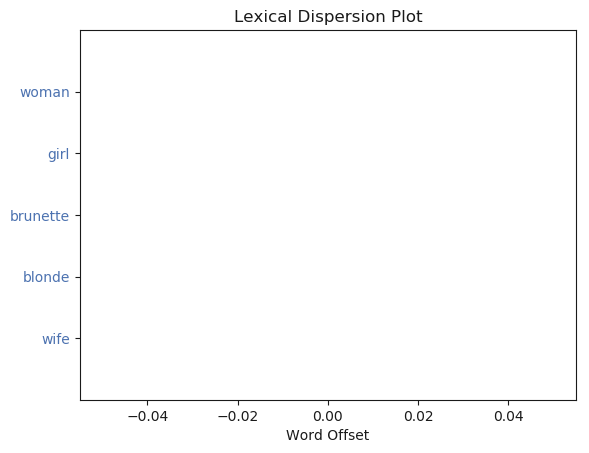

In [371]:

sns.reset_orig() #Seaborn messes with this plot, disabling it
sprt_Text.dispersion_plot(['woman', 'girl' ,'brunette', 'blonde','wife'])
sns.set()

In [121]:
import wordcloud

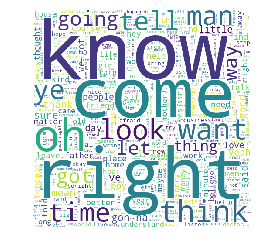

In [122]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(only_1950s['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("text_word_cloud.pdf", format = 'pdf')

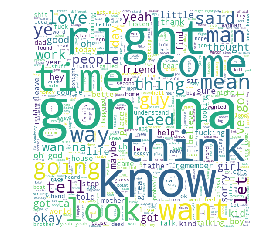

In [144]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(only_2000s['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("text_word_cloud.pdf", format = 'pdf')

In [ ]:
only_30s = only_1930s[:30]

In [ ]:
only_10s = only_2010s[:30]

In [ ]:
only_30s['tokenized_sents'] = only_30s['Text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
only_30s['normalized_sents'] = only_30s['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

In [ ]:
only_10s['tokenized_sents'] = only_10s['Text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
only_10s['normalized_sents'] = only_10s['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

In [408]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

In [409]:
def posCooccurrence(sentences, *posType, makeMatrix = False):
    words = set()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for sent in sentences:
        s = [(w, t) for w, t in lucem_illud_2020.spacy_pos(sent) if t in posType]
        for w, t in s:
            if w not in wordsMap:
                wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in reducedSents:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        for w in g.nodes:
            g.nodes[w]['bipartite'] = wordsMap[w]
        return g

In [413]:
is_1930s =  movdf_norm['Year'].isin(["1930", "1931","1932", "1933", "1934", "1935", "1936", "1937", "1938", "1939"])
only_1930s = movdf_norm[is_1930s]
is_1940s =  movdf_norm['Year'].isin(["1940", "1941","1942", "1943", "1944", "1945", "1946", "1947", "1948", "1949"])
only_1940s = movdf_norm[is_1940s]
is_1950s =  movdf_norm['Year'].isin(["1950", "1951","1952", "1953", "1954", "1955", "1956", "1957", "1958", "1959"])
only_1950s = movdf_norm[is_1950s]
is_1960s =  movdf_norm['Year'].isin(["1960", "1961","1962", "1963", "1964", "1965", "1966", "1967", "1968", "1969"])
only_1960s = movdf_norm[is_1960s]
is_1970s =  movdf_norm['Year'].isin(["1970", "1971","1972", "1973", "1974", "1975", "1976", "1977", "1978", "1979"])
only_1970s = movdf_norm[is_1970s]
is_1980s =  movdf_norm['Year'].isin(["1980", "1981","1982", "1983", "1984", "1985", "1986", "1987", "1988", "1989"])
only_1980s = movdf_norm[is_1980s]
is_1990s =  movdf_norm['Year'].isin(["1990", "1991","1992", "1993", "1994", "1995", "1996", "1997", "1998", "1999"])
only_1990s = movdf_norm[is_1990s]
is_2000s =  movdf_norm['Year'].isin(["2000", "2001","2002", "2003", "2004", "2005", "2006", "2007", "2008", "2009"])
only_2000s = movdf_norm[is_2000s]
is_2010s =  movdf_norm['Year'].isin(["2010", "2011","2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019"])
only_2010s = movdf_norm[is_2010s]

In [414]:
mov_romance = movdf_norm[movdf_norm['Genre'].str.contains('Romance', na=False)] #114 movies
mov_drama = movdf_norm[movdf_norm['Genre'].str.contains('Drama', na=False)] #114 movies
mov_comedy = movdf_norm[movdf_norm['Genre'].str.contains('Comedy', na=False)] #114 movies
mov_horror = movdf_norm[movdf_norm['Genre'].str.contains('Horror', na=False)] #114 movies
mov_scifi = movdf_norm[movdf_norm['Genre'].str.contains('Sci-Fi', na=False)] #114 movies
mov_sport = movdf_norm[movdf_norm['Genre'].str.contains('Sport', na=False)] #114 movies

In [416]:
only_30s = only_1930s[:30]
only_10s = only_2010s[:30]

In [417]:
only_30s['tokenized_sents'] = only_30s['Text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
only_30s['normalized_sents'] = only_30s['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [418]:
only_10s['tokenized_sents'] = only_10s['Text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
only_10s['normalized_sents'] = only_10s['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [419]:
gNV_10 = posCooccurrence(only_10s['normalized_sents'].sum(), 'NN', 'VB')

In [420]:
gNV_10.remove_edges_from([(n1,n2) for n1,n2,d in gNV_10.edges(data = True) if gNV.nodes[n1]['bipartite'] == gNV_10.nodes[n2]['bipartite']])

NameError: name 'gNV' is not defined

In [ ]:
gNV.remove_edges_from([(n1, n2) for n1, n2, d in gNV.edges(data = True) if d['weight'] <= 2])
gNV.remove_nodes_from([n for n in gNV.nodes if len(set(gNV.neighbors(n))) <= 5])

In [ ]:
storyNeighbors = gNV_10.neighbors('woman')
set(storyNeighbors)

In [467]:
only_1930s.head()

,Unnamed: 0,Unnamed: 0.1,Movie Name,Genre,Year,Country,IMDb,Tokenized,Text,word_count,normalized_tokens,Tagged_Female,Tagged_Male,reduced_tokens
0,0,3547424,Goodbye to All That,"Short, Musical",1930,English,290635,"['In', 'the', 'future', 'a', 'computer', 'prog...","@3547424 In the future , a computer program ca...",35320,"['future', 'computer', 'program', 'called', 's...","([future, computer, program, called, skynet, d...","([future, computer, program, called, skynet, d...",[]
1,1,3660608,Abraham Lincoln,"Biography, Drama, History",1930,English,20620,"['Tom', 'Lincoln', 'It', ""'s"", 'a', 'comin', '...",@3660608 Tom Lincoln ! It's a comin ' - Boy or...,49770,"['tom', 'lincoln', 'comin', 'boy', 'gal', 't',...","([tom, lincoln, comin, boy, gal, t, ai, nt, fu...","([tom, lincoln, comin, boy, gal, t, ai, nt, fu...",[]
2,2,60053,All Quiet on the Western Front,"Drama, War",1930,"English, French, German, Latin",20629,"['Thirty', 'thousand', 'From', 'the', 'Russian...",@60053 - Thirty thousand . - From the Russians...,69596,"['russians', 'french', 'russians', 'capture', ...","([russians, french, russians, capture, day, mr...","([russians, french, russians, capture, day, mr...",[]
3,3,3435788,Born Reckless,"Crime, Drama, Film-Noir",1930,"English, Italian, French",20702,"['Louis', 'Louis', 'Beretti', 'Shh', 'Put', 't...",@3435788 Louis ? Louis ? - Beretti ? - Shh ! P...,49565,"['louis', 'louis', 'beretti', 'shh', 'sap', 'k...","([louis, louis, beretti, shh, sap, know, bette...","([louis, louis, beretti, shh, sap, know, bette...",[]
4,4,6922578,King of Jazz,"Animation, Music",1930,English,21025,"['Music', 'hath', 'charms', 'that', 'nothing',...",@6922578 Music hath charms that nothing else h...,33966,"['music', 'hath', 'charms', 'music', 'hath', '...","([music, hath, charms, music, hath, charms, cl...","([music, hath, charms, music, hath, charms, cl...",[]


In [464]:
#Similar parameters to before, but stricter max df and no max num occurrences
TFVectorizer30 = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects30 = TFVectorizer30.fit_transform(only_1930s['Text'])

In [465]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]


In [466]:
only_1930s['reduced_tokens'] = only_1930s['normalized_tokens'].apply(lambda x: dropMissing(x, TFVectorizer30.vocabulary_.keys()))

dictionary = gensim.corpora.Dictionary(only_1930s['reduced_tokens'])

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [456]:
corpus = [dictionary.doc2bow(text) for text in only_1930s['reduced_tokens']]

In [457]:
gensim.corpora.MmCorpus.serialize('mv30.mm', corpus)
mv30 = gensim.corpora.MmCorpus('mv30.mm')

In [458]:
mv30lda = gensim.models.ldamodel.LdaModel(corpus=mv30, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

ValueError: cannot compute LDA over an empty collection (no terms)

In [ ]:
sen1Bow = dictionary.doc2bow(senReleasesTraining['reduced_tokens'][0])
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format(senReleasesTraining['name'][0]))
print("are: {}".format(sen1lda))

In [123]:
import numpy as np #For divergences/distances
import scipy #For divergences/distances
import seaborn as sns #makes our plots look nicer
import sklearn.manifold #For a manifold plot
import json #For API responses
import urllib.parse #For joining urls

# comp-linguistics
import spacy

#Displays the graphs
import graphviz #You also need to install the command line graphviz
% matplotlib inline

In [126]:
import nltk

In [ ]:
Text50 = nltk.Text(Tokens_50)

whitehouseIndex = nltk.text.ConcordanceIndex(whText) 
whitehouseIndex.print_concordance('Whitehouse')

In [20]:
countedWords = wordCounter(word_tokenize(clean_18[1]))
countedWords[:10]

NameError: name 'clean_18' is not defined

In [ ]:
#Doing this in place (changing the original DataFrame) as we don't need the unsorted DataFrame
countedWords.sort_values('count', ascending=False, inplace=True)
countedWords[:100]

In [ ]:
countTarget = 'NN'
targetCounts = {}
for entry in movie_df2['POS_sents'] :
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

In [ ]:
sent = nlp(str(movie_df2['Text']))

In [ ]:
for token in sent:
    print(token.text, token.ent_type_)

In [ ]:
for ent in sent.ents:
    print(ent.text, ent.label_)

In [ ]:
def tag_sents_ner(sentences):
    """
    function which replicates NLTK ner tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for ent in sent.ents:
            pos_sent.append((ent.text, ent.label_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [ ]:
movie_df2['classified_sents'] = movie_df2['sentences'].apply(lambda x: tag_sents_ner(x))

In [ ]:
entityCounts = {}
for entry in movie_df2['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:10]

In [ ]:
nonObjCounts = {}
for entry in movie_df2['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                continue
            elif ent in nonObjCounts:
                nonObjCounts[ent] += 1
            else:
                nonObjCounts[ent] = 1
sortedNonObj = sorted(nonObjCounts.items(), key = lambda x: x[1], reverse = True)
sortedNonObj[:10]

In [ ]:
import nltk

In [ ]:
countsDict = {}
for word in movie_df['Tokenized'].sum():
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)
word_counts[:25]

In [ ]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

In [ ]:
snowball = SnowballStemmer(language = 'english')


In [ ]:
def stemming(words):
    new = []
    stem_words = [snowball.stem(x) for x in (words[:][0])]
    new.append(stem_words)
    return new

In [ ]:
stemlist = stemming(movie_df['Tokenized'])

In [ ]:
import itertools
stems = list(itertools.chain(*stemlist))

In [ ]:
stemcount = wordCounter(stems)

In [ ]:
#The stop list is then all words that occur before the first noun
stop_words_freq = []
for word, count in word_counts:
    if word == 'Whitehouse':
        break
    else:
        stop_words_freq.append(word)
stop_words_freq

In [ ]:
def normalizeTokens(word_list, extra_stop=[]):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    doc = nlp(word_list.lower())
    
    # add the property of stop word to words considered as stop words
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
            normalized.append(str(w.lemma_))

    return normalized

In [379]:
#.sum() adds together the lists from each row into a single list
mov30_cfdist = nltk.ConditionalFreqDist(((len(w), w) for w in only_1930s['normalized_tokens'].sum()))

#print the number of words
print(mov30_cfdist.N())

7857096


In [380]:
def spacy_pos(word_list):
    tags = []
    doc = nlp(word_list.lower())
    for w in doc:
        tags.append((w.text, w.tag_))
    return tags

In [382]:
only_1930s['normalized_tokens_POS'] = [spacy_pos(t) for t in only_1930s['Text']] #Running it on movie names to see associations there, 
#when I rerun this will do it with the original clean raw text, which is not in this dataframe so will add it when I rerun it
#- Cannot run it on the tokenized text

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [383]:
mov30_cfdist_WordtoPOS = nltk.ConditionalFreqDist(only_1930s['normalized_tokens_POS'].sum())
list(mov30_cfdist_WordtoPOS.items())[:10]

[('@3547424', FreqDist({'IN': 1})),
 ('in', FreqDist({'IN': 19818, 'RP': 1818, 'RB': 1405, 'NN': 9, 'JJ': 1})),
 ('the', FreqDist({'DT': 63819})),
 ('future', FreqDist({'NN': 144, 'JJ': 40, 'NNP': 2})),
 (',', FreqDist({',': 148936})),
 ('a',
  FreqDist({'DT': 45307, 'NN': 37, 'RB': 31, 'NNP': 27, 'FW': 14, 'LS': 8})),
 ('computer', FreqDist({'NN': 6})),
 ('program', FreqDist({'NN': 16})),
 ('called', FreqDist({'VBN': 216, 'VBD': 196})),
 ('skynet', FreqDist({'NN': 6}))]

In [404]:
mov30_cfdist_WordtoPOS['woman']

FreqDist({'NN': 1191, 'NNP': 2, 'XX': 1})

In [405]:
mov30_cfdist_WordtoPOS['blonde']

FreqDist({'JJ': 22, 'NNP': 8, 'NN': 8})

In [406]:
mov30_cfdist_WordtoPOS['girl']

FreqDist({'NN': 1608, 'NNP': 13, 'VB': 2, 'VBP': 1})

In [407]:
mov30_cfdist_WordtoPOS['man']

FreqDist({'NN': 4031, 'UH': 34, 'NNP': 32, 'VB': 5, 'VBP': 1})

In [384]:
mov30_cfdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in only_1930s['normalized_tokens_POS'].sum())

In [385]:
mov30_cfdist_POStoWord['JJ'].most_common(5)

[('good', 6315),
 ('little', 3704),
 ('right', 3166),
 ('old', 2183),
 ('sorry', 1646)]

In [397]:
mov30_cfdist_POStoWord['NNP'].most_common(15)

[('@', 12548),
 ('.', 8491),
 ('mr', 5379),
 ('sir', 3826),
 ('miss', 2446),
 ('mrs', 1482),
 ('joe', 718),
 ('mary', 639),
 ('dr', 561),
 ('father', 517),
 ('new', 513),
 ('madame', 470),
 ('bill', 452),
 ('lord', 432),
 ('jack', 430)]

In [402]:
mov30_cfdist_POStoWord['NNPS'].most_common(15)

[('indians', 82),
 ('heavens', 50),
 ('americans', 33),
 ('russians', 24),
 ('arabs', 17),
 ('germans', 16),
 ('groans', 15),
 ('purvis', 15),
 ('seas', 8),
 ('marines', 7),
 ('laughs', 7),
 ('games', 6),
 ('yankees', 6),
 ('ammonites', 6),
 ('chiefs', 5)]

In [401]:
mov30_cfdist_POStoWord['PRP'].most_common(15)

[('you', 101954),
 ('i', 91601),
 ('it', 38840),
 ('me', 22882),
 ('he', 16058),
 ('we', 15708),
 ('him', 9236),
 ('she', 7924),
 ('they', 7906),
 ('her', 4781),
 ('them', 4742),
 ('us', 3226),
 ("'s", 1748),
 ('yourself', 1242),
 ('myself', 1147)]

In [400]:
mov30_cfdist_POStoWord['PRP'].most_common(15)

[('you', 101954),
 ('i', 91601),
 ('it', 38840),
 ('me', 22882),
 ('he', 16058),
 ('we', 15708),
 ('him', 9236),
 ('she', 7924),
 ('they', 7906),
 ('her', 4781),
 ('them', 4742),
 ('us', 3226),
 ("'s", 1748),
 ('yourself', 1242),
 ('myself', 1147)]

In [387]:
mov30_cfdist_POStoWord['NN'].most_common(15)

[('man', 4031),
 ('time', 3941),
 ('way', 3166),
 ('something', 2750),
 ('night', 2699),
 ('anything', 2511),
 ('nothing', 2324),
 ('thing', 2066),
 ('minute', 1978),
 ('money', 1715),
 ('life', 1641),
 ('girl', 1608),
 ('morning', 1566),
 ('everything', 1565),
 ('day', 1540)]

In [ ]:
movie_cpdist_POStoWord = nltk.ConditionalProbDist(movie_cfdist_POStoWord, nltk.ELEProbDist)

#print the most common nouns
print(movie_cpdist_POStoWord['NN'].max())

#And its probability
print(movie_cpdist_POStoWord['NN'].prob(movie_cpdist_POStoWord['NN'].max()))

In [395]:
word_dist = nltk.FreqDist(only_1930s['Tokenized'].str.cat(sep=' '))

In [391]:
rslt = pd.DataFrame(word_dist.most_common(4),
                    columns=['Word', 'Frequency'])

In [392]:
rslt

,Word,Frequency
0,"['In', 'the', 'future', 'a', 'computer', 'prog...",1
1,"['Tom', 'Lincoln', 'It', ""'s"", 'a', 'comin', '...",1
2,"['Thirty', 'thousand', 'From', 'the', 'Russian...",1
3,"['Louis', 'Louis', 'Beretti', 'Shh', 'Put', 't...",1


In [ ]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(movie_df['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("text_word_cloud.pdf", format = 'pdf')

In [ ]:

wc3 = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(movie_df['normalized_tokens_genres'].sum()))
plt.imshow(wc3)
plt.axis("off")
plt.savefig("moviegenre_word_cloud.pdf", format = 'pdf')

In [ ]:
def sent_tokenize(word_list):
    doc = nlp(word_list)
    sentences = [sent.string.strip() for sent in doc.sents]
    return sentences

In [ ]:
def tag_sents_pos(sentences):
    """
    function which replicates NLTK pos tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for token in sent:
            pos_sent.append((token.text, token.tag_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [ ]:
movie_df['tokenized_sents'] = movie_df['Text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
movie_df['normalized_sents'] = movie_df['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

In [ ]:
movie_df = movie_df.join(movie_df['Genre'].str.split(',', expand=True).add_prefix('Genre').fillna(np.nan))

In [ ]:
movie_df_genre = pd.concat([movie_df,movie_df.Genre.str.get_dummies(sep=', ')],1)

In [ ]:
movie_romance = movie_df[movie_df['Genre'].str.contains('Romance', na=False)] #114 movies

In [3]:
movie_df.head()

NameError: name 'movie_df' is not defined

Finally, we measure the co-occurrence of male and female character by finding whether they appear together in the same sentence for movie synopses or in the same paragraph for movie scripts and books

The analysis is based on the scripts of movies from different genres that looks to analyze the gender and minority breakdown within the different movies over time. I will first be doing a POS analysis for noun-verbs and noun-adjective relationships and then the word embedding vector relationships. The word frequency and phrase frequency relationships will also allow us to learn more about how the films function in the context of gender and minority relationships.

The tokenized words can be extracted into different relationship structures for analysis.

Research Question : How do gender and minority relationships between characters change over the decades 

Word Frequency and Counts

First step is to count the word frequency of men and women, race related words in the movie scripts. 

In [24]:
def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pandas.DataFrame(countsForFrame)